In [37]:
import sys
import uproot
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import math
import csv
import io
import matplotlib.colors as colors
from scipy.optimize import curve_fit
from scipy.stats import pearsonr
import astropy
from astropy import stats
from scipy import interpolate
import os

os.chdir("../data")  # moves working directory to data folder

In [38]:
def osc(Amsw, E):
    
    degrad = math.pi/180 # deg.s to rad.s conversion fac.
    
    E = E # 6e6 eV, B8 peak
    peS = 92.5e3/1.673e-27 # m-3, e density of Sun at B8 production point 
    peE = 2.8e3/1.673e-27 # m-3, average e density of Earth 

    Gf =  8.958e-44  #eV m3, Fermi constant
    #Amsw = 1 # divergence from msw theory
    
    ######################################
    # oscillation parameters:

    md12 = 5.14e-5 #eV^2, mass-square diff. 
    md13 = 2.515e-3 #eV^2
    
    a12 = 33.4*degrad   # rad, mixing angle
    a13 = 8.57*degrad
    
    s13 = math.sin(a13)
    c13 = math.cos(a13)
    
    s12 = math.sin(a12)
    c12 = math.cos(a12)
    
    s2a12 = math.sin(2*a12)
    c2a12 = math.cos(2*a12)
    
    ######################################
    
    lrS = ((2*2**0.5)*Gf*Amsw*peS*E*(c13**2))/md12 # ratio of oscillation length and refraction length in Sun
    lrE = ((2*2**0.5)*Gf*Amsw*peE*E*(c13**2))/md12 # " " in Earth
    
    c2a12S = (c2a12 - lrS)/(1 - 2*lrS*c2a12 + lrS**2)**0.5 # mixing angle in Sun matter
    c2a12E = (c2a12 - lrE)/(1 - 2*lrE*c2a12 + lrE**2)**0.5 # " " in Earth
    
    s2a12E = np.sin(np.arccos(c2a12E))
    
    freg = 0.5*(c13**2)*lrE*(s2a12E**2)
    
    pd = (c13**4)*(0.5 + 0.5*c2a12S*c2a12) + s13**4
    
    asym = (2*c2a12S*(c13**2)*freg)/(2*pd - c2a12S*(c13**2)*freg)
    
    return asym, pd

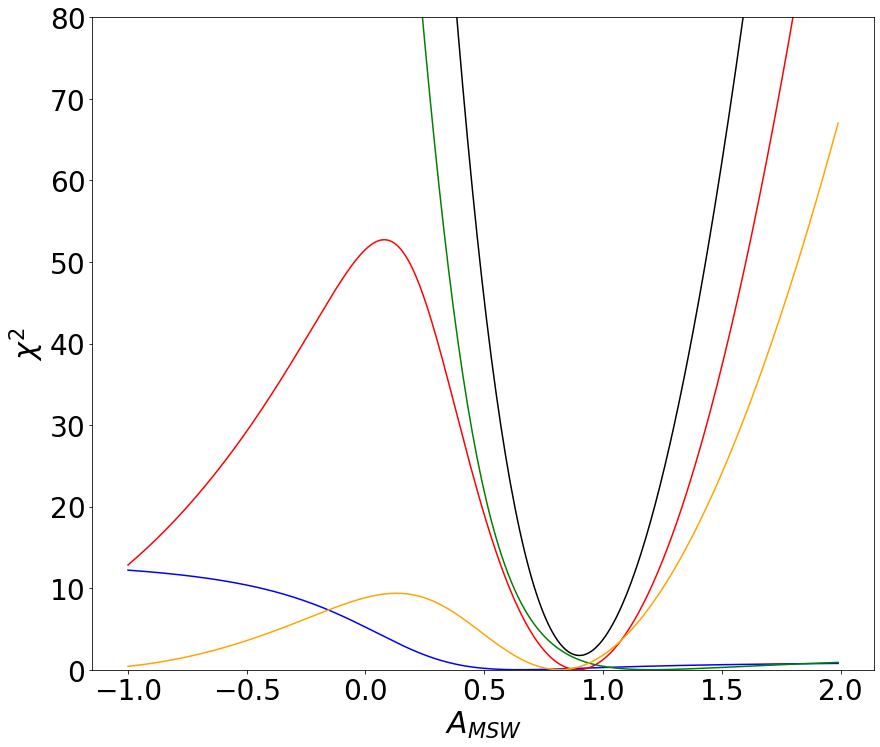

In [39]:
def chisquar(obs, uncer, exp):
    
    chisquar = ((obs - exp)**2)/uncer**2
    
    return chisquar

x = np.arange(-1, 2, 0.01)

survBorex = [0.37, 0.08] # measurement and error
survSNO = [0.317, 0.0183]
asymDUNE = [-0.0856, np.sqrt(0.0083**2 + (0.00856)**2)]
asymDUNE2 = [-0.0856, np.sqrt(0.0083**2 + (0.00856*0.1)**2)]
asymSK = [-0.033, 0.0111]

chiBorex = chisquar(survBorex[0], survBorex[1], osc(x, 6e6)[1])
chiDUNE = chisquar(asymDUNE[0], asymDUNE[1], osc(x, 9.9e6)[0])
chiDUNE2 = chisquar(asymDUNE2[0], asymDUNE2[1], osc(x, 9.9e6)[0])
chiSNO = chisquar(survSNO[0], survSNO[1], osc(x, 6e6)[1])
chiSK = chisquar(asymSK[0], asymSK[1], osc(x, 6e6)[0])

y = chiBorex + chiDUNE + chiSNO + chiSK

####################

plt.figure(figsize=(14,12))

plt.plot(x, chiBorex, color='blue')
plt.plot(x, chiDUNE, color='red')
plt.plot(x, chiSNO, color='green')
plt.plot(x, chiSK, color='orange')
plt.plot(x, y, color='black')

plt.xlabel(r'$A_{MSW}$',fontsize=30)
plt.xticks(fontsize=28)
plt.ylabel(r'$\chi^2$',fontsize=30)
plt.yticks(fontsize=28)

#plt.xlim(0, 2)
plt.ylim(0, 80)
plt.show()

[0.91]
[0.9]
[0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95]
[0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83 0.84 0.85 0.86 0.87
 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97 0.98 0.99 1.   1.01
 1.02 1.03 1.04 1.05 1.06 1.07]


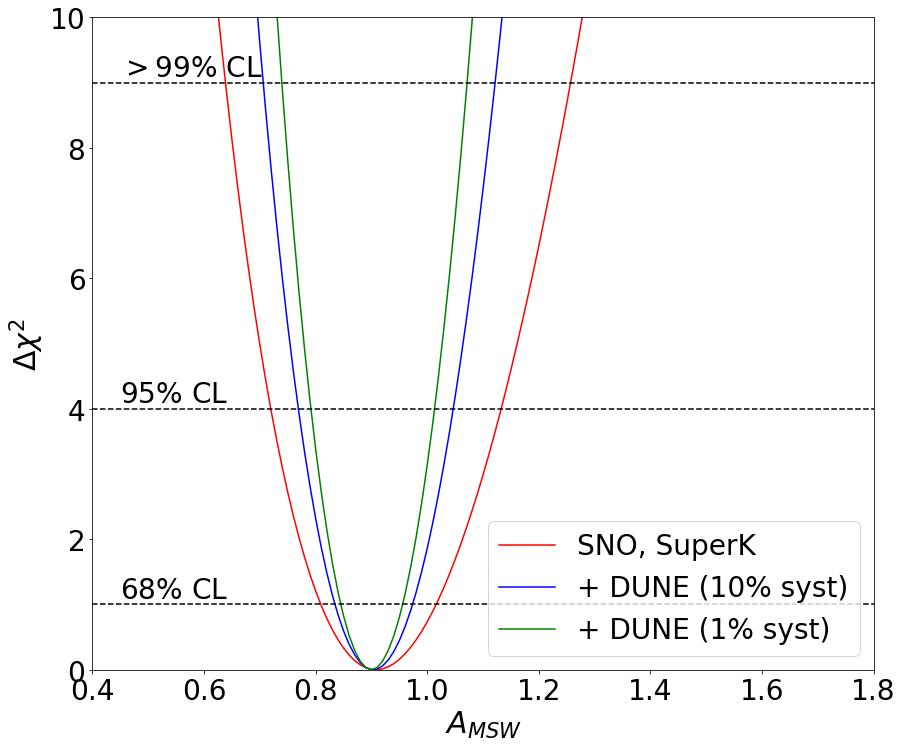

In [44]:
plt.figure(figsize=(14,12))

y = chiSNO + chiSK + chiBorex
chimin = np.min(y)
print(x[y == chimin])
plt.plot(x, y-chimin, color='red', label='SNO, SuperK')

y = chiDUNE + chiSNO + chiSK
chimin = np.min(y)
plt.plot(x, y-chimin, color='blue', label='+ DUNE (10% syst)')

y = chiDUNE2 + chiSNO + chiSK
chimin = np.min(y)
plt.plot(x, y-chimin, color='green', label='+ DUNE (1% syst)')
print(x[y == chimin])
print(x[y - chimin <= 1])
print(x[y - chimin <= 9])

plt.axhline(y=1, color='black', linestyle='--')
plt.axhline(y=4, color='black', linestyle='--')
plt.axhline(y=9, color='black', linestyle='--')

plt.text(0.45, 1.1, r'$68\%$ CL', color='black', fontsize=28)
plt.text(0.45, 4.1, r'$95\%$ CL', color='black', fontsize=28)
plt.text(0.45, 9.1, r'$> 99\%$ CL', color='black', fontsize=28)

plt.xlabel(r'$A_{MSW}$',fontsize=30)
plt.xticks(fontsize=28)
plt.ylabel(r'$\Delta \chi^2$',fontsize=30)
plt.yticks(fontsize=28)

plt.legend(fontsize=28)  #, loc='lower right')

plt.xlim(0.4, 1.8)
plt.ylim(0, 10)

plt.savefig('../figures/mswanalysis.png', bbox_inches='tight')

plt.show()